In [1]:
np=8
using Pkg
Pkg.activate("..")
using Distributed
if nprocs() < np
    addprocs(np-nprocs())
end
@everywhere using Revise, FUSE
using Plots; gr()#plotlyjs();
println("Working with $(nprocs()) processes")

Working with 8 processes


  Activating project at `~/Coding/julia/FUSE`
┌ Info: Precompiling FUSE [e64856f0-3bb8-4376-b4b7-c03396503992]
└ @ Base loading.jl:1423


In [26]:
# dd,ini,act = FUSE.init(:ITER; init_from=:ods, do_plot=true)
# dd,ini,act = FUSE.init(:ITER; init_from=:scalars, do_plot=true)
# dd,ini,act = FUSE.init(:D3D; do_plot=true)
dd,ini,act = FUSE.init(:FPP; version=:v1_demount, do_plot=false)
act.ActorTauenn.transport_model=:h98y2;
# dd,ini,act = FUSE.init(:FPP; version=:v1, do_plot=true)
# dd,ini,act = FUSE.init(:CAT; do_plot=true)
# dd,ini,act = FUSE.init(:HDB5; tokamak=:JET, case=500, do_plot=true)

┌ Warning: /Users/meneghini/Coding/julia/FUSE/cases/.ipynb_checkpoints no longer exists, deleted all methods
└ @ Revise /Users/meneghini/.julia/packages/Revise/VskYC/src/packagedef.jl:651


:h98y2

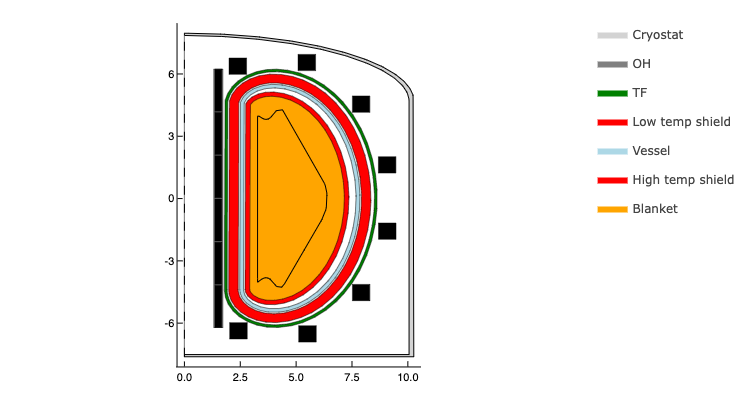

In [27]:
@everywhere function workflow_custom(dd,ini,act)
    FUSE.init(dd,ini,act)
    FUSE.ActorEquilibriumTransport(dd, act)
    FUSE.ActorHFSsizing(dd, act)
    FUSE.ActorLFSsizing(dd, act)
    FUSE.ActorCXbuild(dd, act)
    FUSE.ActorPFcoilsOpt(dd, act; optimization_scheme=:none)
    FUSE.ActorCosting(dd, act)
end

workflow_custom(dd,ini,act)
p=plot(;aspect_ratio=:equal)
plot!(p,dd.build)
plot!(p,dd.pf_active)

In [43]:
continue_results=results
#continue_results=missing
OFL=FUSE.ObjectivesFunctionsLibrary
objective_functions = [OFL[:max_fusion], OFL[:min_cost], OFL[:max_flattop]]
results=FUSE.workflow_multiobjective_optimization(workflow_custom,dd,ini,act,objective_functions;N=100,iterations=10,continue_results=continue_results);

using Metaheuristics

X=[]
F=[]
PX=[]
PF=[]
for res in results.state.convergence
    x=transpose(hcat([res.population[k].x for k in 1:length(res.population)]...))
    f=transpose(hcat([res.population[k].f for k in 1:length(res.population)]...))
    f = hcat([objective_functions[k].(f[:,k]) for k in 1:length(objective_functions)]...)

    psol=Metaheuristics.get_non_dominated_solutions(res.population)
    px=transpose(hcat([psol[k].x for k in 1:length(psol)]...))
    pf=transpose(hcat([psol[k].f for k in 1:length(psol)]...))
    pf = hcat([objective_functions[k].(pf[:,k]) for k in 1:length(objective_functions)]...)

    push!(X,x)
    push!(F,f)
    push!(PX,px)
    push!(PF,pf)
end

using JLD2
JLD2.jldsave("FUSEMOOP.jld2";X,F,PX,PF)

Running on 8 processes
== Actuators ==
ec.power_launched
- units: W
- description: EC launched power
- value: 4.5e8
- base: 4.5e8
- default: missing
- lower: 3.0e7
- upper: 1.0e8
core_profiles.zeff
- units: 
- description: Effective ion charge
- value: 1.1
- base: 1.1
- default: missing
- lower: 1.1
- upper: 2.5
core_profiles.greenwald_fraction
- units: 
- description: Greenwald fraction, ne_vol / ne_gw
- value: 0.9
- base: 0.9
- default: missing
- lower: 0.8
- upper: 0.95

== Objectives ==
max_fusion [MW]
min_cost [$M]
max_flattop [hours]

Restarting simulation


Iteration  90%|█████████████████████████▎  |  ETA: 0:05:41 ( 5.69  m/it)

3459.690677 seconds (12.44 M allocations: 768.299 MiB, 0.07% gc time)


"EC launched power"

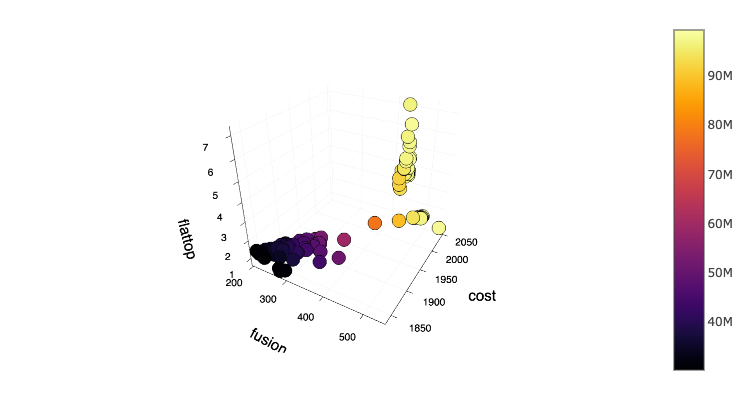

In [48]:
#plotlyjs();
n_color=1
display(opt[n_color].description)

p=plot()
for (kk,(px,pf)) in enumerate(zip(PX,PF))
    if kk<10
        continue
    end
    scatter!(p, pf[:,1],pf[:,2],log10.(pf[:,3]),
        xlabel=split(string(objective_functions[1].name),"_")[2],
        ylabel=split(string(objective_functions[2].name),"_")[2],
        zlabel=split(string(objective_functions[3].name),"_")[2],
        marker_z=px[:,n_color],
        colorbar_title=opt[n_color].description,
        label="")#,zlim=[0,1E4])
end
display(p)

# opt=FUSE.opt_parameters(ini)
# p=plot()
# for (px,pf) in zip(PX,PF)
#     scatter!(p, px[:,1],px[:,2],px[:,3],xlabel=opt[1].description,ylabel=opt[2].description,zlabel=opt[3].description,marker_z=log10.(pf[:,3]),label="")
# end
# display(p)

In [6]:
#plotlyjs();

@recipe function plot_MultiobjectiveOptimizationResults(results::MultiobjectiveOptimizationResults; index=-1)

    if index===missing
        states = results.state.convergence
    elseif index == -1
        states = [results.state]
    else 
        states = results.state.convergence[index]
    end

    X=[]
    F=[]
    PX=[]
    PF=[]
    for res in results.state.convergence
        x=transpose(hcat([res.population[k].x for k in 1:length(res.population)]...))
        f=transpose(hcat([res.population[k].f for k in 1:length(res.population)]...))
        f = hcat([objective_functions[k].(f[:,k]) for k in 1:length(objective_functions)]...)

        psol=Metaheuristics.get_non_dominated_solutions(res.population)
        px=transpose(hcat([psol[k].x for k in 1:length(psol)]...))
        pf=transpose(hcat([psol[k].f for k in 1:length(psol)]...))
        pf = hcat([objective_functions[k].(pf[:,k]) for k in 1:length(objective_functions)]...)

        push!(X,x)
        push!(F,f)
        push!(PX,px)
        push!(PF,pf)
    end

    p=plot()
    for (px,pf) in zip(PX,PF)
        scatter!(p, pf[:,1],pf[:,2],pf[:,3],xlabel=objective_functions[1].name,ylabel=objective_functions[2].name,zlabel=objective_functions[3].name,marker_z=px[:,3],label="")
    end
    display(p)

    opt=FUSE.opt_parameters(ini)
    p=plot()
    for (px,pf) in zip(PX,PF)
        scatter!(p, px[:,1],px[:,2],px[:,3],xlabel=opt[1].description,ylabel=opt[2].description,zlabel=opt[3].description,marker_z=log10.(pf[:,3]),label="")
    end
    display(p)
end


LoadError: UndefVarError: MultiobjectiveOptimizationResults not defined

In [52]:
using TGLFNN
TGLFNN.BSON.bson("test.bson",results)


LoadError: MethodError: no method matching bson(::String, ::FUSE.MultiobjectiveOptimizationResults)
[0mClosest candidates are:
[0m  bson(::String; kws...) at ~/.julia/packages/BSON/rOaki/src/write.jl:89
[0m  bson(::String, [91m::AbstractDict[39m) at ~/.julia/packages/BSON/rOaki/src/write.jl:87